In [2]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/night vision dataset'
os.chdir(dataset_path)

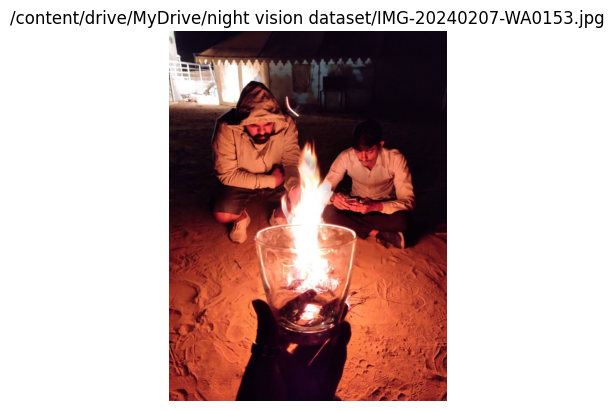

In [4]:
images_path = '/content/drive/MyDrive/night vision dataset'
target_image_file = '/content/drive/MyDrive/night vision dataset/IMG-20240207-WA0153.jpg'
target_image_path = os.path.join(images_path, target_image_file)

if os.path.exists(target_image_path):
    target_image = cv2.imread(target_image_path)
    target_image_rgb = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)

    plt.imshow(target_image_rgb)
    plt.title(target_image_file)
    plt.axis('off')
    plt.show()
else:
    print(f"Error: Image '{target_image_file}' not found in the specified directory.")

## Night Vision Effect

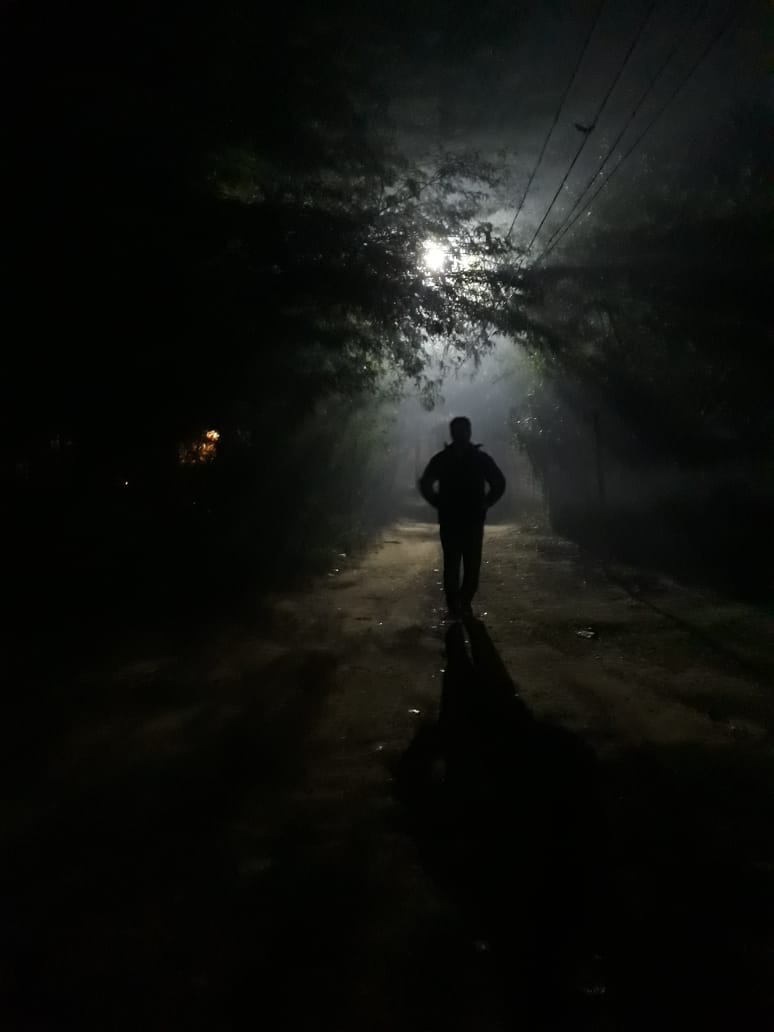

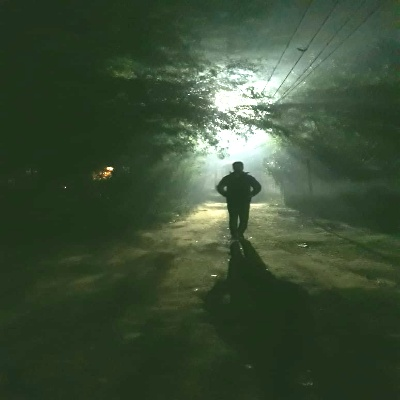

In [9]:
import numpy as np
from IPython.display import display, Image

def create_blank(width, height, rgb_color=(0, 0, 0)):
    image = np.zeros((height, width, 3), np.uint8)
    color = tuple(reversed(rgb_color))
    image[:] = color
    return image

# Path to the input image
input_image_path = '/content/drive/MyDrive/night vision dataset/IMG-20240207-WA0204.jpg'
# Read the input image
image = cv2.imread(input_image_path)

# Check if the image was successfully loaded
if image is None:
    raise ValueError(f"Unable to read the image from '{input_image_path}'.")

# Define the desired output size
output_width = 400
output_height = 400

# Night Vision Effect
new_image = np.zeros((output_height, output_width, 3), np.uint8)
new_image = np.clip(cv2.resize(image + 25, (output_width, output_height)), 0, 255)
greenimg = create_blank(output_width, output_height, (32, 194, 14))
new_frame = cv2.addWeighted(cv2.resize(image, (output_width, output_height)), 0.9, greenimg, 0.1, 0)
new_image = cv2.addWeighted(new_image, 1, new_frame, 1, 0)

# Display the original and enhanced images
display(Image(filename=input_image_path, width=output_width, height=output_height))
display(Image(data=cv2.imencode('.jpg', new_image)[1].tobytes(), format='png', width=output_width, height=output_height))

## Spatial, Frequency and Hybrid Enhancement

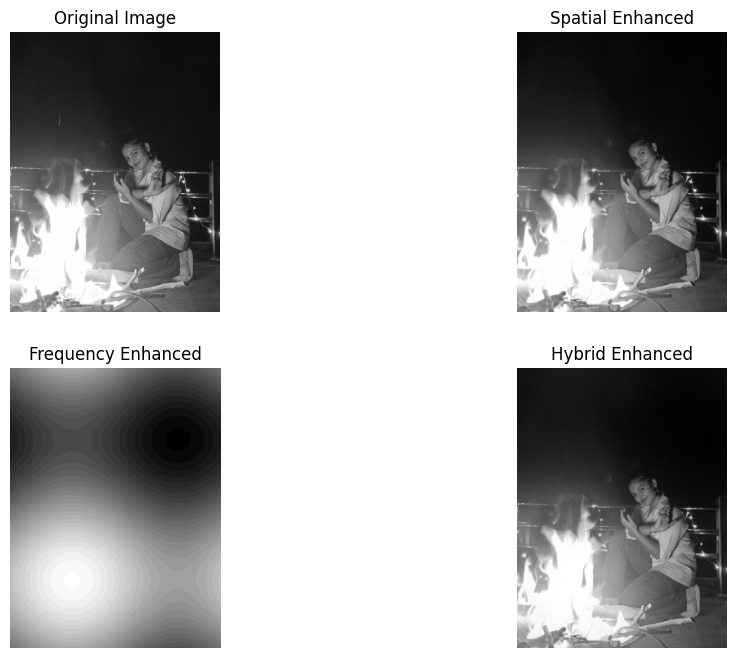

In [ ]:
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import numpy as np

def hybrid_enhancement(image_path, spatial_filter_size=5, alpha=0.5):
    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply spatial domain enhancement (e.g., filtering, sharpening)
    spatial_enhanced = cv2.medianBlur(original_image, spatial_filter_size)

    # Apply frequency domain enhancement using Fourier transform
    spectrum = fftshift(fft2(original_image))
    magnitude_spectrum = np.abs(spectrum)
    phase_spectrum = np.angle(spectrum)

    # Create a high-pass filter in the frequency domain (e.g., using a Gaussian)
    rows, cols = original_image.shape
    center_row, center_col = rows // 2, cols // 2
    gaussian_high_pass_row = np.exp(-((np.arange(rows) - center_row) ** 2) / (2 * alpha ** 2))
    gaussian_high_pass_col = np.exp(-((np.arange(cols) - center_col) ** 2) / (2 * alpha ** 2))
    gaussian_high_pass = np.outer(gaussian_high_pass_row, gaussian_high_pass_col)

    # Apply the high-pass filter to the magnitude spectrum
    enhanced_magnitude = magnitude_spectrum * gaussian_high_pass

    # Combine the enhanced magnitude spectrum with the original phase spectrum
    enhanced_spectrum = enhanced_magnitude * np.exp(1j * phase_spectrum)

    # Inverse Fourier transform to obtain the enhanced image
    frequency_enhanced = np.abs(ifft2(ifftshift(enhanced_spectrum))).astype(np.uint8)

    # Combine spatial and frequency enhancements
    hybrid_enhanced = cv2.addWeighted(spatial_enhanced.astype(np.float32), 0.5, frequency_enhanced.astype(np.float32), 0.5, 0)

    return original_image, spatial_enhanced, frequency_enhanced, hybrid_enhanced

# Perform hybrid enhancement
original, spatial_enhanced, frequency_enhanced, hybrid_enhanced = hybrid_enhancement(chosen_image_file)

# Display the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(spatial_enhanced, cmap='gray')
plt.title('Spatial Enhanced')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(frequency_enhanced, cmap='gray')
plt.title('Frequency Enhanced')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(hybrid_enhanced, cmap='gray')
plt.title('Hybrid Enhanced')
plt.axis('off')

plt.show()

## DUALISTIC HISTOGRAM EQUILIZATION (DHE)
Step 1: Define a function that performs the process of DHE on an input image

In [ ]:
import matplotlib.colors
import imageio
import scipy, scipy.misc, scipy.signal
import sys
import numpy as np
import matplotlib.pyplot as plt

def build_is_hist(img):
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    Img = np.zeros((hei + 4, wid + 4, ch))
    for i in range(ch):
        Img[:, :, i] = np.pad(img[:, :, i], (2, 2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:, :, 0] = hsv[:, :, 0] * 255
    hsv[:, :, 1] = hsv[:, :, 1] * 255
    hsv[hsv > 255] = 255
    hsv[hsv < 0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    fh = np.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]])
    fv = fh.conj().T

    H = hsv[:, :, 0]
    S = hsv[:, :, 1]
    I = hsv[:, :, 2]

    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    dIh[dIh == 0] = 0.00001
    dIv[dIv == 0] = 0.00001
    dI = np.sqrt(dIh**2 + dIv**2).astype(np.uint32)
    di = dI[2:hei + 2, 2:wid + 2]

    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    dSh[dSh == 0] = 0.00001
    dSv[dSv == 0] = 0.00001
    dS = np.sqrt(dSh**2 + dSv**2).astype(np.uint32)
    ds = dS[2:hei + 2, 2:wid + 2]

    h = H[2:hei + 2, 2:wid + 2]
    s = S[2:hei + 2, 2:wid + 2]
    i = I[2:hei + 2, 2:wid + 2].astype(np.uint8)

    Imean = scipy.signal.convolve2d(I, np.ones((5, 5)) / 25, mode='same')
    Smean = scipy.signal.convolve2d(S, np.ones((5, 5)) / 25, mode='same')

    Rho = np.zeros((hei + 4, wid + 4))
    for p in range(2, hei + 2):
        for q in range(2, wid + 2):
            tmpi = I[p - 2:p + 3, q - 2:q + 3]
            tmps = S[p - 2:p + 3, q - 2:q + 3]
            corre = np.corrcoef(tmpi.flatten('F'), tmps.flatten('F'))
            Rho[p, q] = corre[0, 1]

    rho = np.abs(Rho[2:hei + 2, 2:wid + 2])
    rho[np.isnan(rho)] = 0
    rd = (rho * ds).astype(np.uint32)
    Hist_I = np.zeros((256, 1))
    Hist_S = np.zeros((256, 1))

    for n in range(0, 255):
        temp = np.zeros(di.shape)
        temp[i == n] = di[i == n]
        Hist_I[n + 1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i == n] = rd[i == n]
        Hist_S[n + 1] = np.sum(temp.flatten('F'))

    return Hist_I, Hist_S

Step 2: Define DHE

In [ ]:
def dualistic_histogram_equalization(img, alpha=0.5):
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha * hist_s + (1 - alpha) * hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)

    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    i = hsv[:, :, 2].astype(np.uint8)

    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0, 255):
        i_s[i == n] = s_r[n + 1] / 255.0
    i_s[i == 255] = 1
    hsi_o = np.stack((h, s, i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)

    result = result * 255
    result[result > 255] = 255
    result[result < 0] = 0
    return result.astype(np.uint8)

Step 3: Print output images

<ipython-input-44-1a6d4ffff661>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_name)


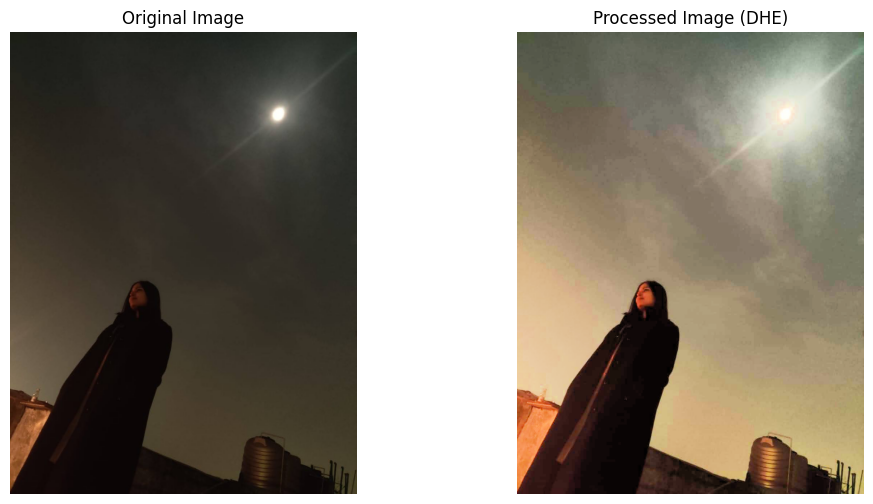

In [ ]:
def main(img_name):
    # original image
    img = imageio.imread(img_name)

    # Dualistic Histogram Equalization
    result = dualistic_histogram_equalization(img)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(result)
    axes[1].set_title('Processed Image (DHE)')
    axes[1].axis('off')

    plt.show()

if __name__ == '__main__':
    img_name = '/content/drive/MyDrive/night vision dataset/IMG-20240207-WA0148.jpg'
    main(img_name)